# SIR and SEIR KF

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [2]:
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())

Last updated on  Wed Apr  8 14:07:47 2020


In [3]:
import numpy as np
import pandas as pd
import matplotlib

In [4]:
fontsize=14
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }
plt.rcParams["font.size"     ] = fontsize


In [5]:
import c19.basic_models as cbm

from c19.types import SIR, SIR2

from scipy.integrate import odeint
#import scipy.integrate as spi
#from scipy.interpolate import interp1d

In [6]:
#from dataclasses import dataclass, field

In [7]:
#from c19.types import SIR, SEIR

In [8]:
#import c19.basic_models as cbm
#import c19.core_functions as cf
#import c19.plotting as cplt
#import c19.utils as ut

In [9]:
import c19.kfmysir as kfmsir

## SIR Model


$$
\frac{dS}{dt} = - \frac{\beta S I}{N} \\
\frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I \\
\frac{dR}{dt} = \gamma I
$$


And $H$

$$
H_{i} = \begin{pmatrix} \beta \frac{S}{N}  I_{i-1} & - I_{i.1} \\
                              0         &   I_{i-1} \end{pmatrix} I_{i-1} 
$$

## Generate samples

In [10]:
N                = 4.7e+7
ND               = 80
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
RX, Gamma        = 3.5, 1./5 
Beta             = Gamma * RX
I0               = 1E-5
S0               = 1 - I0
R0               = 0
Y0               = (S0, I0, R0)

In [11]:
sir = cbm.compute_sir(N, Y0, RX, Gamma, t_range, ts = [(0, 200)], ms=[1.0]) 

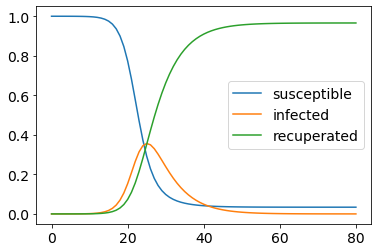

In [12]:
plt.plot(sir.t, sir.S, label = 'susceptible');
plt.plot(sir.t, sir.I, label = 'infected');
plt.plot(sir.t, sir.R, label = 'recuperated');
plt.legend();

In [13]:
def modelsir_rvs(sir):
    N = sir.N
    ts = sir.t
    cs = N* sir.I, N*sir.R
    cs = [np.array(val) for val in zip(*cs)]
    ns = kfmsir._rvs(cs)
    return ts, cs, ns

In [14]:
ts, cs, ns = modelsir_rvs(sir)

### SIR: measurments

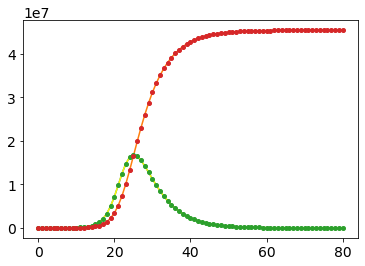

In [15]:
plt.plot(ts, cs);
plt.plot(sir.t, sir.N * sir.I, color = 'yellow')
plt.plot(ts, ns, ls = '', marker = 'o', ms = 4.);

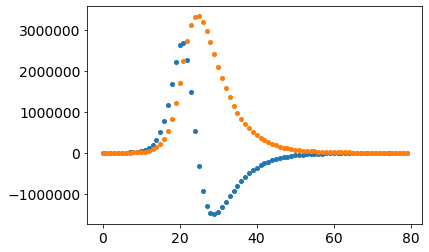

In [16]:
ms, ums = kfmsir.delta_ms(ns)
plt.plot(ts[:-1], ms, marker = 'o', ls = '', ms = 4.);

### SIR Fit 

In [17]:
x0 = np.array((1., 1.))
xs, uxs = kfmsir.sir_kf(ts, ns, x0, N)

x-best :  [0.80529705 0.25346535]
x-true :  0.7000000000000001 0.2


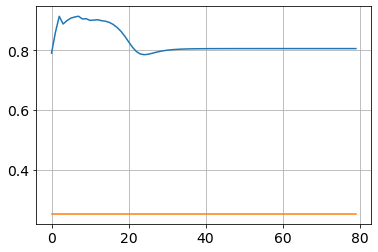

In [18]:
plt.plot(ts[:-1], xs);
plt.grid();
print('x-best : ', xs[ND-10]);
print('x-true : ', Beta, Gamma)

## SIR2 model


- In the simplest version of SIR "recovered labels both people who truly recovers and people who dies of the illness". In this extension we can count both of them.
$$
\frac{dS}{dt} = - \frac{\beta}{N} S I \\
\frac{dI}{dt} = \frac{\beta}{N} I - \gamma I \\
\frac{dR}{dt} = (1 - \phi) \gamma I \\
\frac{dD}{dt} = \phi \gamma I -g D \\
M =g D \\
$$

In [19]:
N                = 4.7e+7
ND               = 100
TS               = 1.0
t_start          = 0.0 
t_end            = ND 
t_inc            = TS
t_range          = np.arange(t_start, t_end+t_inc, t_inc)
T                = 5.
Td               = 5.
Q                = 0.
S0               = 1 - I0
R0               = 0
D0               = 0
Y0               = (S0, I0, R0, D0)

In [20]:
#N                     = 1e6 #4.7e+7
R0, Gamma, Sigma, Rho = 3.5, 1./5., 1./5, 1./7.
Phi                   = 0.01 # 0.01
Beta                  = R0  * Gamma
PhiGamma              = Phi * Gamma 

In [21]:
#def compute_sir2(N, Y0, R0, Gamma, Phi, G, Lamda, k,
#                  t_range, ts = [(0, 400)], ms=[1.0]):
#sir2 = cbm.compute_sir2(N, Y0, R0, Gamma, Phi, Rho, 0, 0, t_range)

In [22]:
def sir2_deriv(y, t, M, beta, gamma, phi, g):
    """
    Prepare differential equations for SEIR
    Includes a mitigation function
    """

    S, I, R, D = y
    dSdt = -beta * M(t) * S * I
    dIdt = beta * M(t) * S * I - gamma * I
    dRdt = (1 - phi) * gamma * I
    dDdt = phi * gamma * I - g * D
    return dSdt, dIdt, dRdt, dDdt

def _sir2():
    Gamma = 1/T
    G     = 1/Td
    Beta  = Gamma * R0
    ts =[(0, ND)]
    ms = [1 - Q/100]
    M = cbm.mitigation_function(t_range, ts, ms)

    ret = odeint(sir2_deriv, Y0, t_range, args=(M, Beta, Gamma, Phi, G))
    S, I, R, D = ret.T
    M              = 1 - S - I - R - D

    sir      = SIR2(N = N, S=S, I=I, R=R, D=D, M=M, P=0,
                     beta=Beta, R0=R0, gamma=Gamma,
                     phi=Phi, g=G, lamda=0, k=0,
                     t= t_range)
    return sir

In [23]:
sir2 = _sir2()

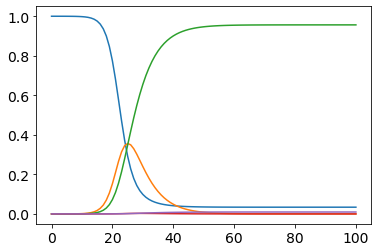

In [24]:
plt.plot(sir2.t, sir2.S);
plt.plot(sir2.t, sir2.I);
plt.plot(sir2.t, sir2.R);
plt.plot(sir2.t, sir2.D);
plt.plot(sir2.t, sir2.M);

### SIR2 measurements

In [25]:
def modelsir2_rvs(sir):
    N = sir.N
    ts = sir.t
    cs = N * sir.I, N * sir.R, N * sir.D, #N * sir.M
    cs = [np.array(val) for val in zip(*cs)]
    ns = kfmsir._rvs(cs)
    return ts, cs, ns

In [26]:
ts, cs, ns = modelsir2_rvs(sir2)

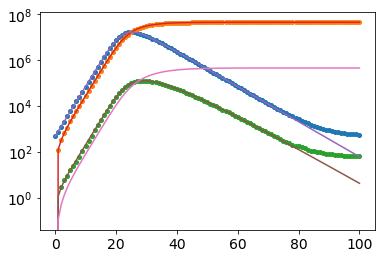

In [27]:
#plt.plot(ts, cs);
plt.plot(ts, ns, ls= '', marker='o', ms=4);
plt.yscale('log')
plt.plot(sir2.t, sir.N * sir2.R);
plt.plot(sir2.t, sir.N * sir2.I);
plt.plot(sir2.t, sir.N * sir2.D);
plt.plot(sir2.t, sir.N * sir2.M);

### SIR2 fits

x-best :  [0.70346052 0.20740682 0.00253069 0.25745191]
x-true :  0.7000000000000001 0.2 0.002 0.2


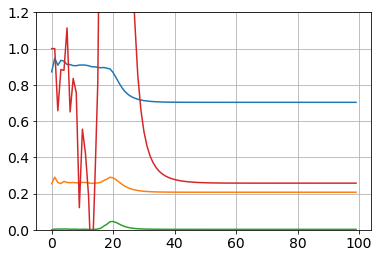

In [28]:
x0 = np.array((1., 1., 1., 1.))
xs, uxs = kfmsir.sir2_kf(ts, ns, x0, N)
plt.plot(ts[:-1], xs);
plt.grid();
print('x-best : ', xs[80]); plt.ylim(0., 1.2);
print('x-true : ', Beta, Gamma, Gamma*Phi, 1/5.)

## Trying to fit to SIR2c complete with death 

### SIR2c measurements with death

In [29]:
def modelsir2c_rvs(sir):
    N = sir.N
    ts = sir.t
    cs = N * sir.I, N * sir.R, N * sir.D, N * sir.M
    cs = [np.array(val) for val in zip(*cs)]
    ns = kfmsir._rvs(cs)
    return ts, cs, ns

In [30]:
ts, cs, ns = modelsir2c_rvs(sir2)

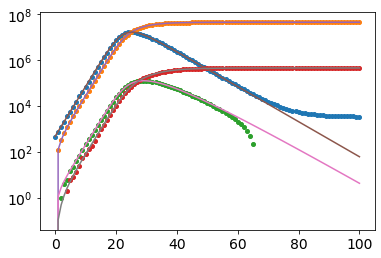

In [31]:
#plt.plot(ts, cs);
plt.plot(ts, ns, ls= '', marker='o', ms=4);
plt.yscale('log')
plt.plot(sir2.t, sir.N * sir2.R);
plt.plot(sir2.t, sir.N * sir2.I);
plt.plot(sir2.t, sir.N * sir2.D);
plt.plot(sir2.t, sir.N * sir2.M);

### SIR2c fit with death

x-best :  [0.81410955 0.25757576 0.00782609 0.53853903]
x-true :  0.7000000000000001 0.2 0.002 0.2


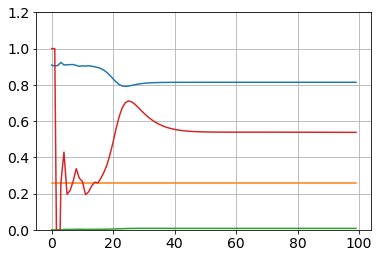

In [32]:
x0 = np.array((1., 1., 1., 1.))
xs, uxs = kfmsir.sir2c_kf(ts, ns, x0, N)
plt.plot(ts[:-1], xs);
plt.grid();
print('x-best : ', xs[80]); plt.ylim(0., 1.2);
print('x-true : ', Beta, Gamma, Gamma*Phi, 1/5.)

In [33]:
#------